<b><center>Homework 3 - Team East Meets West<center></b>
<b><center>Due 11:59pm EST Wednesday October 12<center></b>
Team: <b>Team East Meets West </b> (Cindy Liu and Hazel John)

### <b>Python Packages:</b>
We started with the usual set of python packages; utilizing scikit-learn modules for preprocessing as well as classification.

We also set a standard size for all the figures.

In [15]:
# Getting the initial library imports out of the way
import pandas as pd
import numpy as np
import warnings
import logging
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import time

from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import Imputer
from sklearn.svm import SVC

# Set the parameters for Matplotlib figure size
# for the rest of the Notebook as in section notes
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

# Ignore warning to present clean output
warnings.filterwarnings('ignore')

### <b> Modularization </b>
From a software engineering aspect, we moved code into simple functions for reusability. We were able to creates reusable modules as we solved each problem. We didn't go to the extent of creating our own packages or splitting into multiple modules.

### <b>Process Improvements</b>
We added couple of process improvement midway through the process. They helped immensely with model development and tracking of our iterations. 

#### <b>1. Runtime Reduction</b>
We created a simple function to get the subset of the data. For example, running GridSearch with a smaller sample helped us debug parameter interaction errors without wasting a lot of time.

In [16]:
def createDataFileSubsets(rowsToCopy, sTrain, sTruth, sTest, sBlind):
    # Name the data subsets to be created
    sTrain_sub = 'trainingDataSubSet.txt'
    sTruth_sub = 'trainingTruthSubSet.txt'
    sTest_sub = 'testDataSubSet.txt'
    sBlind_sub = 'blindDataSubSet.txt'
    
    # Create a list of files to read from and the corresponding files to write to
    data_in = [sTrain, sTruth, sTest, sBlind]
    data_out = [sTrain_sub, sTruth_sub, sTest_sub, sBlind_sub]

    # Read in the files and write out a subset
    for i, data_set in enumerate(data_in):
        with open(data_set, 'r') as inf:
            with open(data_out[i], 'w') as outf:
                for row in range(rowsToCopy):
                    outf.write(inf.readline())
    
    # Return the new filenames
    return (sTrain_sub, sTruth_sub, sTest_sub, sBlind_sub)

#### <b>2. Logging: </b>
It became harder to keep track what was tried in each iterations as we tried more things and ran through the daily submissions. So we implemented logging to help us track the iterations better

In [17]:
def initRunID():
    # Generate an ID to identify each run
    global g_runID
    g_runID = '%s'%datetime.now().strftime('%m-%d-%Y_%H%M')
    
def initLogging(name):
    
    # Initialize log confid
    log_fn = './%s_%s.log'%(name,g_runID)
                        
    # create logger 
    global logger
    logger = logging.getLogger('HW3')
    
    # reset handlers so as not to have to exit shell 
    # between two executions
    logger.handlers = []
    
    logger.setLevel(logging.DEBUG)
    
    # create file handler which logs even debug messages
    fh = logging.FileHandler(log_fn)
    fh.setLevel(logging.DEBUG)
    
    # create console handler with a same log level
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    
    # create formatter and add it to the handlers
    formatter = logging.Formatter('%(asctime)s - %(levelname)s: %(message)s',
                                  datefmt='%m/%d/%Y %I:%M:%S %p')
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)
    
    # add the handlers to the logger
    logger.addHandler(fh)
    logger.addHandler(ch)  

# generate a runid
initRunID()

# initialize logging
initLogging('HW3_run')

### <b>Data Visualization</b>
We implemented a few functions for data exploration. 

In [30]:
def exploreData(X):
    # This takes too long with all the rows, so we use a subset
    # This helps us have a quick look at the feature values
    sns.heatmap(X[0:20], xticklabels=20, yticklabels=False)
    plt.show()
    
    # Do some further analysis of the data to see how it is 
    # distributed within the range seen above
    # First check the distribution of column means
    plt.hist(X.mean(axis=0))
    plt.xlabel('mean')
    plt.ylabel('frequency')
    plt.show()

    # Also check distribuyion of column variance
    plt.hist(X.var(axis=0))
    plt.xlabel('variance')
    plt.ylabel('frequency')
    plt.show()

def plotFeatureHistograms(X, total_rows, nrows, ncols):
    # Make sure the total_rows we want is not larger than data size
    total_rows = total_rows if total_rows < X.shape[1] else X.shape[1]
    
    # Calculate number of iteration needed to get through all columns
    total_plots = nrows*ncols
    num_iterations = int(total_rows/total_plots + (1 if total_rows%total_plots != 0 else 0))
    start = cur = 0
    
    # Draw a nrows x ncols grid till we run out of rows
    for i in range(num_iterations):
        cur = start*total_plots
        fig = plt.figure()
        for j in range(total_plots):
            if (cur+j >= total_rows):
                break
            ax=fig.add_subplot(nrows, ncols, j+1)
            X[cur+j].hist(ax=ax)
        fig.tight_layout()
        plt.show()
        start += 1
        
def plotFeatureCorrelations(X):
    sns.set(context="paper", font="monospace")

    corrmat = X.corr()
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(14, 10))

    # Draw the heatmap using seaborn
    _ = sns.heatmap(corrmat, vmax=.8, square=True)
    plt.show()
            

#### <b>1. Load the Data</b>
Since we want to look at the entire data set, we set DEBUG to False and we load all the files.

In [19]:
DEBUG = False

# Specify the data files we need
sTrain = 'trainingData.txt'
sTruth = 'trainingTruth.txt'
sTest = 'testData.txt'
sBlind = 'blindData.txt'

# Create a smaller set of files to use for debugging, and update 
# file names to point to the new set
if (DEBUG):
    (sTrain, sTruth, sTest, sBlind) = createDataFileSubsets(DEBUG_FILESIZES, sTrain, sTruth, sTest, sBlind)

# Reading files
read_start = time.time()
    
logger.info('Reading files - %s, %s, %s and %s' % (sTrain, sTruth, sTest, sBlind))

# Read in the data
X = pd.read_csv(sTrain, sep='\t', header=None)
Y = pd.read_csv(sTruth, sep='\t', header=None)
# Flatten output labels array
Y = np.array(Y).ravel()
Xtest = pd.read_csv(sTest, sep="\t", header=None)
Xblind = pd.read_csv(sBlind, sep="\t", header=None)
# Drop the last column for the Blind data set
Xblind.drop(Xblind.columns[334], axis=1, inplace=True)
    
read_end = time.time()
    
# Print some timings
logger.info('Time to load data: %0.3fs' % (read_end - read_start))

# Log the size of data
logger.info('X.shape: %s, Y.shape: %s, Xtest.shape: %s, Xblind.shape: %s' %
            (X.shape, Y.shape, Xtest.shape, Xblind.shape))

10/15/2016 10:34:58 AM - INFO: Reading files - trainingData.txt, trainingTruth.txt, testData.txt and blindData.txt
10/15/2016 10:35:01 AM - INFO: Time to load data: 3.854s
10/15/2016 10:35:01 AM - INFO: X.shape: (17378, 334), Y.shape: (17378,), Xtest.shape: (8179, 334), Xblind.shape: (20050, 334)


#### <b>2. Overall Statistics</b>
Given the large instance size, we looked at the heatmap of the feature values and looked at the distribution of the statistics for the features.

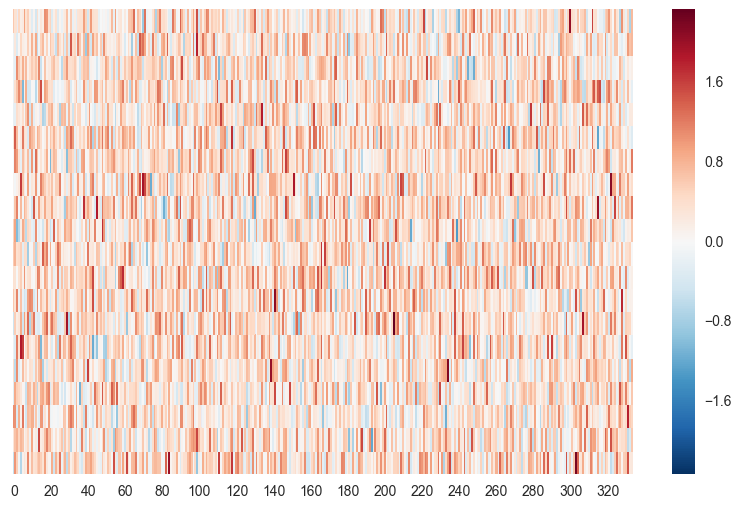

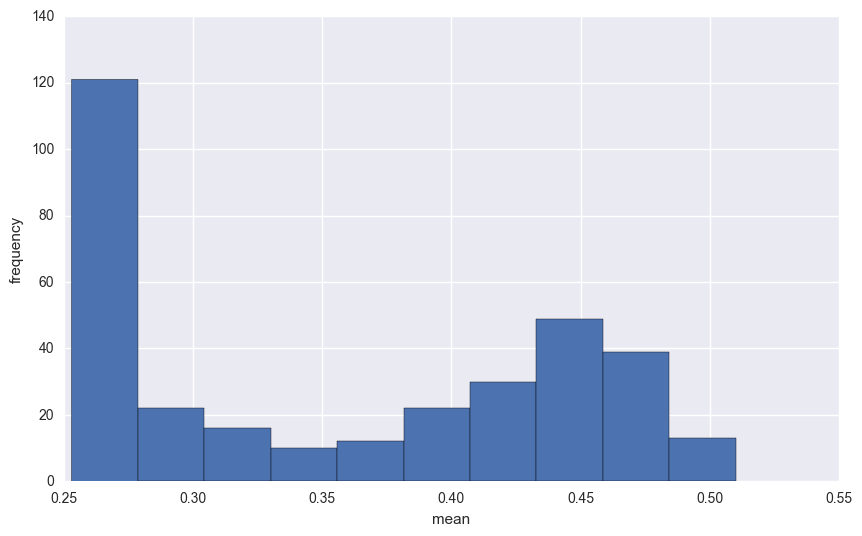

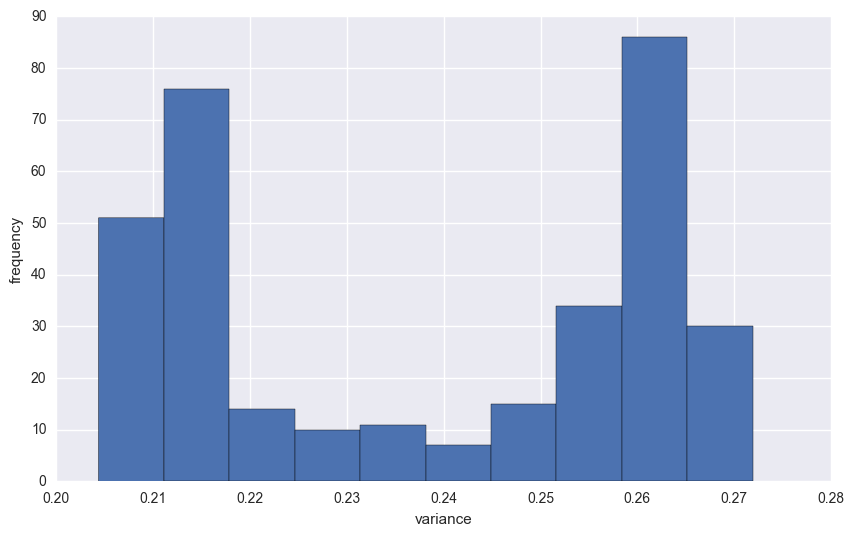

In [20]:
# Do some data exploration
exploreData(X)

We look at the values for the top 20 rows and from the heatmap colors are see a similarity in the range of values.
We can also see that there is somewhat of a spread for the mean and variance for the features. This implies that we might want to standardize the data.

#### <b>3. Individual Distribution</b>
We also look at the distribution of values per feature. 
NOTE: We only show the top 48 rows to improve readability.

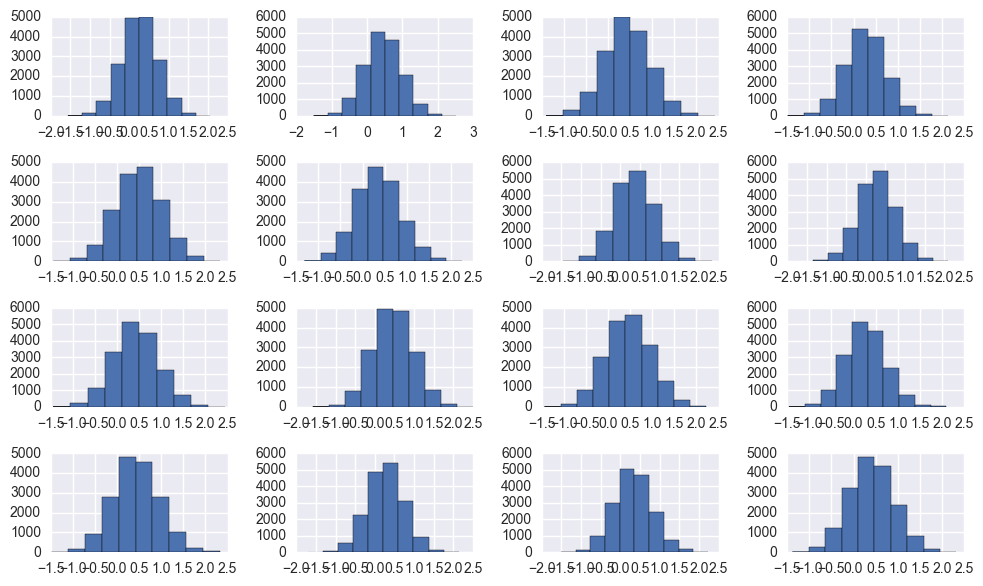

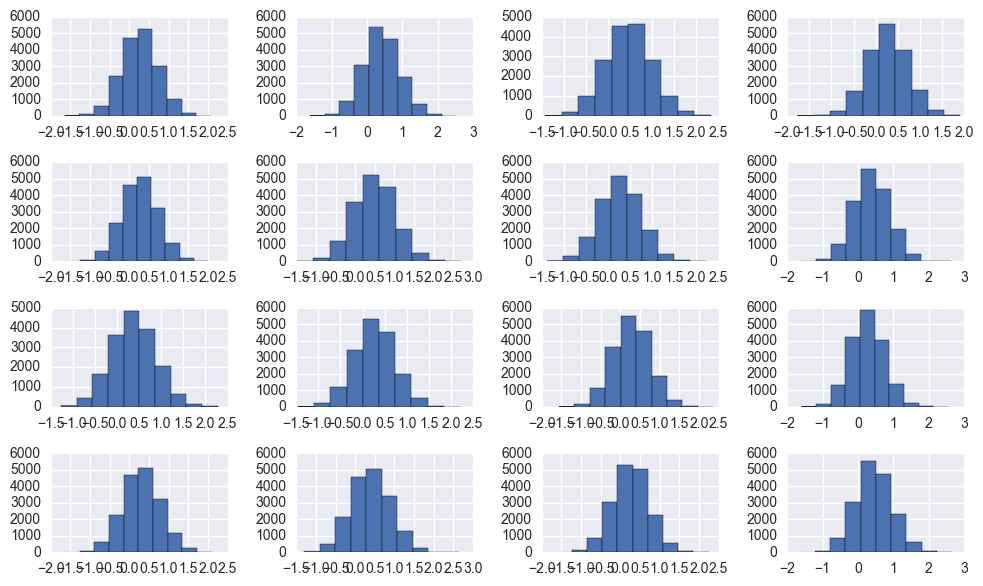

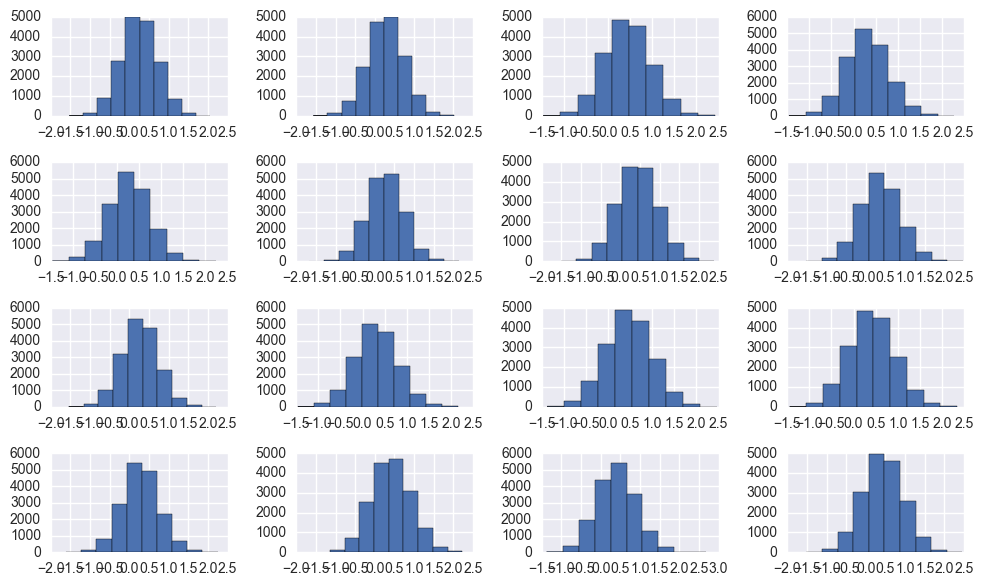

In [21]:
# Look at the histogram of the first 96 rows in 4x4 grids
plotFeatureHistograms(X, 48, 4, 4)

We don't see a lot of outliers and seemed somewhat normally distributed, so we decided against log transformation though it might have been beneficial.

#### <b> Feature Interactions </b>
We checked if interactions would be a problem by plotting the correlations. However with the large number of features, it is hard to see the details.

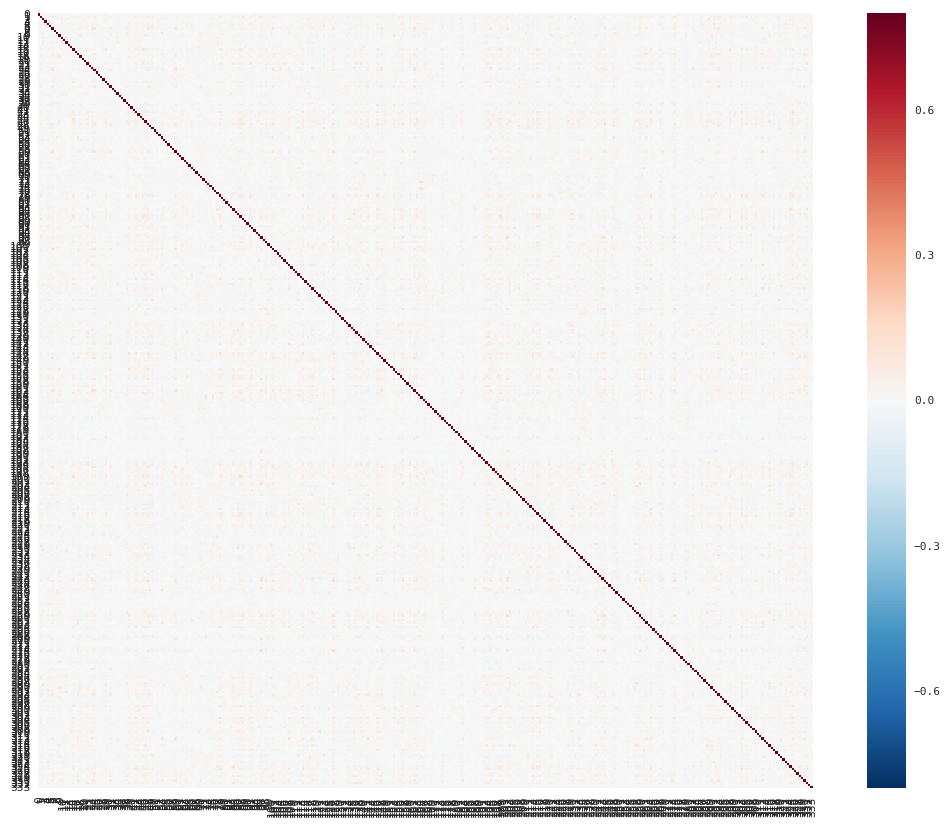

In [32]:
# Look at the correlations
plotFeatureCorrelations(X)

### <b> Handling Missing Values</b>
The first step was to fill the missing values with something other than 0. Decided to go with the median value rather than mean since median is more resistant to outliers and since we don’t know what the features stood for, we wanted to make sure we select an existing value. [Reference](http://www.biostat.jhsph.edu/~iruczins/teaching/jf/ch14.pdf "Missing Data").

However, we decided to use mean later as the distributions of the feature values didn't look very skewed.

With the homework extension, we also decided to try using other approaches. We downloaded fancyimpute which included knn, softimpute and other methods. We tried K nearest neighbors (k=3), but wasn't able to get it submitted for the last friday run.

<b> FancyImpute Setup:</b>

The package was downloaded from [here](https://pypi.python.org/pypi/fancyimpute "FancyImpute").
And installed as follows:
~~~~
sudo pip install fancyimpute-0.0.19.tar.gz
~~~~
It has a dependency on tensorflow, so decided to create a new conda environment and install tensorflow as follows:
~~~~
sudo conda create -n tensorflow python=3.5 anaconda numpy matplotlib seaborn beautifulsoup4 scikit-learn
sudo conda install –n tensorflow -c conda-forge tensorflow
~~~~

Since I had installed Anaconda as root (to enable it for all users), I had to do the following to fix error running Anaconda navigator. Or this could be a known issue with protobuf as seen in some issue lists
~~~~
sudo chmod o+r /Applications/anaconda/lib/python3.5/site-packages/protobuf-3.0.0b2-py3.5.egg-info/*.txt`
~~~~

In [22]:
from fancyimpute import KNN

def replaceMissingValues(X, strategy):
    # Impute missing values based on the strategy passed in
    # Strategy can be 'mean', 'median' or 'most_frequent'
    imp = Imputer(missing_values='NaN', copy=False, strategy=strategy, axis=0)
    imp.fit_transform(X)   
    logger.info('Missing values replaced using %s' % strategy)
    
def replaceMissingValueswFancyImpute(X):
    # Use 3 nearest rows which have a feature to fill in each row's missing features
    knnImpute = KNN(k=3)
    X_imputed = knnImpute.complete(X)
    return X_imputed

Given that we weren't able to get the fancyimpute setup working prior to the last run, we decided to submit with the sklearn 'mean' imputer

In [23]:
# Impute missing values, we can choose, mean, median or most frequent
# Choosing mean as we didn't notice skewness in the attribute distribution
replaceMissingValues(X, strategy = 'mean')
#X = replaceMissingValueswFancyImpute(X)

10/15/2016 10:35:10 AM - INFO: Missing values replaced using mean


### <b> Feature Reduction </b>
The initial runs gave us results close to 90% accuracy (as measured by the area under the ROC curve).

We implemented Feature reduction as a way to improve our results. [Reference](http://scikit-learn.org/stable/modules/feature_selection.html "Feature Selection")

#### <b>1. Variance Threshold</b>
We first implemented feature reduction using the variance threshold option. 

#### <b> 2. Tree-based feature selection</b>
Feature selection with variance threshold didn't give us as much benefit as expected, so we explored further and were able to see improvements when we implemented the tree based method.


In [25]:
def reduceFeaturesbyVariance(Xtrain, Xtest, threshold = 0.22):
    # one way of removing low importance features is to 
    # remove features with low variability
    # Looking at the variance histogram, we can 
    # choose 0.22 as a good cutoff
    selector = VarianceThreshold(threshold = threshold)
    selector.fit(Xtrain)
    
    # Print out the number of features retained
    kept_features = selector.get_support(indices=True)
    logger.info('Variance Threshold %0.2f: Keeping %d, out of %d features' 
                % (threshold, len(kept_features), Xtrain.shape[1]))

    # Reduce dataset to only include selected features
    train_reduced = selector.transform(Xtrain)
    test_reduced = selector.transform(Xtest)
    
    return (train_reduced, test_reduced)
    
def reduceFeatureswithExtraTrees(Y, Xtrain, Xtest):
    # Build a forest and compute the feature importances
    forest = ExtraTreesClassifier(n_estimators=250,
                                  random_state=0)
    
    forest.fit(Xtrain, Y)
    importances = forest.feature_importances_
    
    # Compute the std. deviations
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    
    # Log top 10 features
    logger.info("Feature ranking:")
    for f in range(10):
        logger.info("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
    # Plot the feature importances of the forest
    plt.title("Feature importances")
    plt.bar(range(Xtrain.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(Xtrain.shape[1]), indices, rotation=90)
    plt.xlim([-1, Xtrain.shape[1]])
    ax = plt.axes()
    # Skip some of the feature labels to reduce crowding
    ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
    ax.set_xlabel('features') 
    ax.set_ylabel('importance')
    plt.show()
    
    # select features based on importance weights.
    # by default it uses mean importance as the threshold
    selector = SelectFromModel(forest, prefit=True)
        
    # Print out the number of features retained
    kept_features = selector.get_support(indices=True)
    logger.info('ExtraTreeClassifier: Keeping %d, out of %d features' %
                (len(kept_features), Xtrain.shape[1]))
            
    # Reduce dataset to only include selected features    
    train_reduced = selector.transform(Xtrain)
    test_reduced = selector.transform(Xtest)
    return (train_reduced, test_reduced)  

We do the feaures reduction with both VarianceThreshold and Tree-based method.

10/15/2016 10:36:00 AM - INFO: Variance Threshold 0.22: Keeping 198, out of 334 features
10/15/2016 10:36:23 AM - INFO: Feature ranking:
10/15/2016 10:36:23 AM - INFO: 1. feature 325 (0.007953)
10/15/2016 10:36:23 AM - INFO: 2. feature 303 (0.007857)
10/15/2016 10:36:23 AM - INFO: 3. feature 78 (0.007834)
10/15/2016 10:36:23 AM - INFO: 4. feature 114 (0.007125)
10/15/2016 10:36:23 AM - INFO: 5. feature 42 (0.006950)
10/15/2016 10:36:23 AM - INFO: 6. feature 264 (0.006496)
10/15/2016 10:36:23 AM - INFO: 7. feature 47 (0.006446)
10/15/2016 10:36:23 AM - INFO: 8. feature 163 (0.005986)
10/15/2016 10:36:23 AM - INFO: 9. feature 146 (0.005985)
10/15/2016 10:36:23 AM - INFO: 10. feature 298 (0.005470)


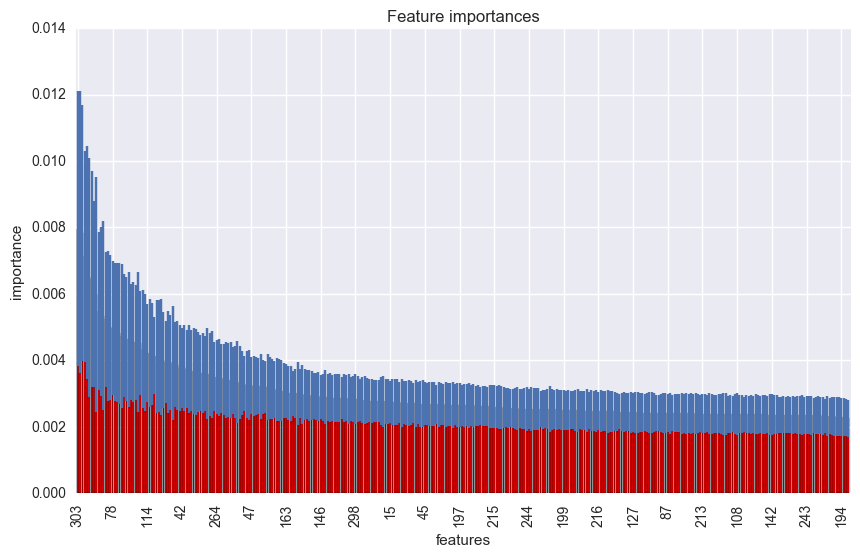

10/15/2016 10:36:25 AM - INFO: ExtraTreeClassifier: Keeping 97, out of 334 features


In [26]:
# Reduce features using variance threshold
(train_varreduced, test_varreduced) = reduceFeaturesbyVariance(X, Xtest, 0.22)

# Reduce features using tree based model
(train_treereduced, test_treereduced) = reduceFeatureswithExtraTrees(Y, X, Xtest)

Feature reduction with the variance threshold of 0.22 retained 198 features and tree-based approach retains 97 (using mean importance as the threshold). We could have reduced futher as a percntage of mean, but had to stop due to time constraints as well as other things we wanted to try.

#### <b> Accuracy Verification</b>
We defined two functions, one was the AUC calculation as provided in the baseline. We also wanted to look at the F1 scores to be able to evaluate models based on its performance with respect to both precision and recall 

In [27]:
def getAUCByClass(model, X, Y, classes=[1, 2, 3, 4]):
    
    # Get the predictions
    model_predict = model.predict_proba(X)

    # Binarize the output
    y_bin = label_binarize(Y, classes=classes)
    
    #Calculate AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], model_predict[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    return(roc_auc)
    
def getF1ScoreByClass(model, X, Y, classes=[1, 2, 3, 4]):
    
    # Get the predictions
    model_predict = model.predict_proba(X)
    # Binarize the predictions
    model_predict = (model_predict == model_predict.max(axis=1, keepdims=True)).astype(int)

    # Binarize the output
    y_bin = label_binarize(Y, classes=classes)
    
    # Calculate F1 scores
    f1_scores = dict()
    for i in range(4):
        f1_scores[i] = f1_score(y_bin[:, i], model_predict[:, i])
    
    return(f1_scores)

#### <b> Helper Methods </b>
We also created a helper method for the final creation of test/blind data predictions based on the code provided in the baseline file.

In [28]:
def createSubmission(model, Xtest, isBlind):
    #Create submission
    y_final_prob = model.predict_proba(Xtest)
    y_final_label = model.predict(Xtest)
    
    sample = pd.DataFrame(np.hstack([y_final_prob.round(5),y_final_label.reshape(y_final_prob.shape[0],1)]))
    sample.columns = ["prob1","prob2","prob3","prob4","label"]
    sample.label = sample.label.astype(int)
        
    # Create results filename 
    filename = 'TeamEastMeetsWest-%s-%s.csv'%('blind' if isBlind else 'test', g_runID) 

    #Submit this file to dropbox
    sample.to_csv(filename,sep="\t" ,index=False, header=None)
    logger.info('Submission file created: %s' % filename)
    

<b>NOTE: </b>So as to reduce runtime while showing our progressive efforts, we start off by creating a subset. And we'll be using the smaller subset to show our steps.

In [6]:
# Specify the data files we need
sTrain = 'trainingData.txt'
sTruth = 'trainingTruth.txt'
sTest = 'testData.txt'
sBlind = 'blindData.txt'

# Create a smaller set of files to use for debugging, and update 
# file names to point to the new set
(sTrain, sTruth, sTest, sBlind) = createDataFileSubsets(500, sTrain, sTruth, sTest, sBlind) 

FileNotFoundError: [Errno 2] No such file or directory: 'blindData.txt'

<b> STEP 1: </b>
We started our iterations with the baseline file as it provided a good framework to start the rest of the explorations. The first thing that stood out was that we were filling of the missing values with zeroes.

So for the first run, that was the thing we tacked first.

We had a number of methods in play in order to track our model development and save time on failed runs:

In [18]:
# Ignore warning to present clean output
warnings.filterwarnings('ignore')

# Added ability to debug with smaller datasets
DEBUG = False
if DEBUG:
    TRAINING_DATA = 'trainingDataSubSet.txt'
    TRAINING_TRUTH = 'trainingTruthSubSet.txt'
    TEST_DATA = 'testDataSubSet.txt'
else:
    TRAINING_DATA = 'trainingData.txt'
    TRAINING_TRUTH = 'trainingTruth.txt'
    TEST_DATA = 'testData.txt'

def initRunID():
    # Generate an ID to identify each run
    global g_runID
    g_runID = '%s'%datetime.now().strftime('%m-%d-%Y_%H%M')    

def initLogging(name):
    
    # Initialize log confid
    log_fn = './%s_%s.log'%(name,g_runID)
                        
    # create logger 
    global logger
    logger = logging.getLogger('HW3')
    
    # reset handlers so as not to have to exit shell 
    # between two executions
    logger.handlers = []
    
    logger.setLevel(logging.DEBUG)
    
    # create file handler which logs even debug messages
    fh = logging.FileHandler(log_fn)
    fh.setLevel(logging.DEBUG)
    
    # create console handler with a higher log level
    ch = logging.StreamHandler()
    ch.setLevel(logging.ERROR)
    
    # create formatter and add it to the handlers
    formatter = logging.Formatter('%(asctime)s - %(levelname)s: %(message)s',
                                  datefmt='%m/%d/%Y %I:%M:%S %p')
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)
    
    # add the handlers to the logger
    logger.addHandler(fh)
    logger.addHandler(ch)  

The first thing we do is try to get an overall idea of what we're working with:

In [4]:
def exploreData(X):
    # Do initial analysis of the data
    plt.hist(X.var(axis=0))
    plt.xlabel('variance')
    plt.ylabel('frequency')
    plt.show()
    plt.hist(X.mean(axis=0))
    plt.xlabel('mean')
    plt.ylabel('frequency')
    plt.show()
    
    # This takes too long with all the rows, so we use a subset
    # We see a similar range of values in all columns
    sns.heatmap(X[0:20], xticklabels=20, yticklabels=False)

We chose to impute missing values using means, as it seemed to work fairly well.

In [5]:
def replaceMissingValues(X):
    # Impute missing values, we can choose, mean, median or most frequent
    # Choosing mean as a standard
    strategy = 'mean'
    imp = Imputer(missing_values='NaN', copy=False, strategy=strategy, axis=0)
    imp.fit_transform(X)   
    logger.info('Missing values replaced using %s' % strategy)

We also tried a couple of methods for feature reduction. The first was by variance

In [6]:
def reduceFeaturesbyVariance(Xtrain, Xtest, threshold = 0.22):
    # one way of removing low importance features is to 
    # remove features with low variability
    # Looking at the variance histogram, we can 
    # choose 0.22 as a good cutoff
    selector = VarianceThreshold(threshold = threshold)
    selector.fit(Xtrain)
    
    # Print out the number of features retained
    kept_features = selector.get_support(indices=True)
    logger.info('Variance Threshold %0.2f: Keeping %d, out of %d features' 
                % (threshold, len(kept_features), Xtrain.shape[1]))

    # Reduce dataset to only include selected features
    Xtrain = selector.transform(Xtrain)
    Xtest = selector.transform(Xtest)

Ultimately we went with the random forests method for determining feature importance

In [7]:
def reduceFeatureswithExtraTrees(Y, Xtrain, Xtest):
    # Build a forest and compute the feature importances
    forest = ExtraTreesClassifier(n_estimators=250,
                                  random_state=0)
    
    forest.fit(Xtrain, Y)
    importances = forest.feature_importances_
    
    # Compute the std. deviations
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    
    # Log top 10 features
    logger.info("Feature ranking:")
    for f in range(10):
        logger.info("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(Xtrain.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(Xtrain.shape[1]), indices, rotation=90)
    plt.xlim([-1, Xtrain.shape[1]])
    ax = plt.axes()
    # Skip some of the feature labels to reduce crowding
    ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
    ax.set_xlabel('features') 
    ax.set_ylabel('importance')
    plt.show()
    
    # select features based on importance weights.
    # by default it uses mean importance as the threshold
    selector = SelectFromModel(forest, prefit=True)
        
    # Print out the number of features retained
    kept_features = selector.get_support(indices=True)
    logger.info('ExtraTreeClassifier: Keeping %d, out of %d features' %
                (len(kept_features), Xtrain.shape[1]))
            
    # Reduce dataset to only include selected features    
    Xtrain = selector.transform(Xtrain)
    Xtest = selector.transform(Xtest)

We also tried a couple of different ways of scoring our results, since when we first started we had ridiculously high AUC scores and felt we needed to use a second method to make sure it wasn't all a fluke

In [8]:
def getAUCByClass(model, X, Y, classes=[1, 2, 3, 4]):
    
    # Get the predictions
    model_predict = model.predict_proba(X)

    # Binarize the output
    y_bin = label_binarize(Y, classes=classes)
    
    #Calculate AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], model_predict[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    return(roc_auc)
    
def getF1ScoreByClass(model, X, Y, classes=[1, 2, 3, 4]):
    
    # Get the predictions
    model_predict = model.predict_proba(X)
    # Binarize the predictions
    model_predict = (model_predict == model_predict.max(axis=1, keepdims=True)).astype(int)

    # Binarize the output
    y_bin = label_binarize(Y, classes=classes)
    
    # Calculate F1 scores
    f1_scores = dict()
    for i in range(4):
        f1_scores[i] = f1_score(y_bin[:, i], model_predict[:, i])
    
    return(f1_scores)

Predictions and submission file creation (largely unchanged from the original code you provided)

In [9]:
def createSubmission(model, Xtest, filename):
    #Create submission
    y_final_prob = model.predict_proba(Xtest)
    y_final_label = model.predict(Xtest)
    
    sample = pd.DataFrame(np.hstack([y_final_prob.round(5),y_final_label.reshape(y_final_prob.shape[0],1)]))
    sample.columns = ["prob1","prob2","prob3","prob4","label"]
    sample.label = sample.label.astype(int)
    
    #Submit this file to dropbox
    sample.to_csv(filename,sep="\t" ,index=False, header=None)
    logger.info('Submission file created: %s' % filename)

We started out with the method in the code provided at the beginning. Since there are so many parameters to tweak for each classifier, we ran a grid search to more efficiently identify the optimal parameters for our model.

In [10]:
def runRandomForestwithGridSearch(Y, Xtrain, Xtest):
    
    # Note time to run this setup 
    run_start = time.time()
    
    # Reduce feature based on importance
    reduceFeatureswithExtraTrees(Y, Xtrain, Xtest)
    
    # Specify the parameters to tune
    param_grid = {'estimator__n_estimators':[20, 30], 
                  'estimator__max_depth':[10, 20], 
                  'estimator__min_samples_split':[4, 6],
                  'estimator__min_samples_leaf':[2, 4],
                  'estimator__max_features': ['sqrt', 0.25]}
    
    model_to_set = OneVsRestClassifier(RandomForestClassifier(random_state=25, oob_score = True), -1)

    gs_start = time.time()
    model_tuning = GridSearchCV(model_to_set, 
                            param_grid = param_grid, 
                            scoring='f1_weighted',
                            iid=False)
    gs_end = time.time()
    logger.info('Time to run grid search (RandomForest): %0.3fs'% (gs_end - gs_start))

    # Fit the model
    model_tuning.fit(Xtrain, Y)
        
    logger.info('Best score = %d' % model_tuning.best_score_)
    logger.info('Best params = %s' % model_tuning.best_params_)
    logger.info('AUC per class = %s' % 
                getAUCByClass(model_tuning, Xtrain, Y, classes=[1, 2, 3, 4]))
    logger.info('F1 Score per class = %s' % 
                getF1ScoreByClass(model_tuning, Xtrain, Y, classes=[1, 2, 3, 4]))
                
    # Create results filename 
    result_fn = 'TeamEastMeetsWest-%s.csv'%file_id  
    
    createSubmission(model_tuning, Xtest, result_fn)
    
    # Note the end time
    run_end = time.time()
    logger.info('Time to run analysis(RandomForest): %0.3fs'% (run_end - run_start))

The second method we tried was using SVM. We found that even with mostly default parameters, SVM gave us a much better-performing model (in terms of prediction accuracy) than the random forest classifier.

In [12]:
def runSVM(Y, Xtrain, Xtest):
    # Note time to run this setup
    run_start = time.time()

    # Normalize data since accuracy of SVM can severely degrade if it isn't
    # Scale data to normal distribution (gaussian,  mean = 0, variance = 1)
    scaler = StandardScaler().fit(Xtrain)
    X_scaled = scaler.transform(Xtrain)
    Xtest_scaled = scaler.transform(Xtest)

    # Reduce feature based on importance
    reduceFeatureswithExtraTrees(Y, X_scaled, Xtest_scaled)

    # Guessing on these parameters because running with gridsearch took much too long, so I'm
    #   using the results of smaller runs (largest size = first 5000 rows of training dataset)
    clf = SVC(probability=True, cache_size=1000, C=0.1, kernel='sigmoid', gamma=0.1, class_weight='balanced')

    # Fit the model
    clf.fit(X_scaled, Y)

    logger.info('AUC per class = %s' %
                getAUCByClass(clf, X_scaled, Y, classes=[1, 2, 3, 4]))
    logger.info('F1 Score per class = %s' %
                getF1ScoreByClass(clf, Xtrain, Y, classes=[1, 2, 3, 4]))

    # Create results filename
    result_fn = 'TeamEastMeetsWest-%s.csv' % file_id

    if not DEBUG:
        # Predict for the test data and create submission
        createSubmission(clf, Xtest_scaled, result_fn)

    run_end = time.time()
    logger.info('Time to run analysis(SVC): %0.3fs' % (run_end - run_start))

We also used the grid search method with SVM, but it took so much longer than the previous grid searches (we estimate it would have taken ~18 hours to complete) that we ended up just running it on a few subsets of the data to get an idea of which parameters to focus on and some starting values, and running plain SVM on the full dataset.

In [11]:
def runSVMwithGridSearch(Y, Xtrain, Xtest):
    
    # Note time to run this setup 
    run_start = time.time()
       
    # Normalize data since accuracy of SVM can severely degrade if it isn't
    # Scale data to normal distribution (gaussian,  mean = 0, variance = 1)
    scaler = StandardScaler().fit(Xtrain)
    X_scaled = scaler.transform(Xtrain)
    Xtest_scaled = scaler.transform(Xtest)
    
    # Reduce feature based on importance
    reduceFeatureswithExtraTrees(Y, X_scaled, Xtest_scaled)
    
    param_grid = {
        'kernel': ['poly', 'linear', 'sigmoid'],
        'degree': [2, 4, 5],
        'gamma': [.1, .25, .5],
        'C': [.1, .25, .5]
    }
    
    clf = SVC(probability=True, cache_size=1000)
    
    gs_start = time.time()
    clf_tuned = GridSearchCV(clf, param_grid=param_grid)
    gs_end = time.time()
    
    logger.info('Time to run grid search(SVC): %0.3fs'% (gs_end - gs_start))

    # Fit the model
    clf_tuned.fit(X_scaled, Y)

    logger.info('Best score = %d' % clf_tuned.best_score_)
    logger.info('Best params = %s' % clf_tuned.best_params_)
    logger.info('AUC per class = %s' % 
                getAUCByClass(clf_tuned, X_scaled, Y, classes=[1, 2, 3, 4]))
    logger.info('F1 Score per class = %s' % 
                getF1ScoreByClass(clf_tuned, Xtrain, Y, classes=[1, 2, 3, 4]))
                
    # Create results filename 
    result_fn = 'TeamEastMeetsWest-%s.csv'%file_id  
    
    # Predict for the test data and create submission
    createSubmission(clf_tuned, Xtest_scaled, result_fn)
    
    run_end = time.time()
    logger.info('Time to run analysis(SVC): %0.3fs'% (run_end - run_start))

We additionally tried further improving our decision tree method using AdaBoost, to see how it compared to SVM.

In [13]:
def runDecisionTreewithAdaboost(Y, Xtrain, Xtest):
    
    # Note time to run this setup 
    run_start = time.time()
    
    # Reduce feature based on importance
    reduceFeatureswithExtraTrees(Y, Xtrain, Xtest)
    
    model_start = time.time()
    model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
                               n_estimators=50,
                               learning_rate=1.5,
                               algorithm="SAMME")
    model_end = time.time()
    logger.info('Time to run AdaBoost(DecisionTree): %0.3fs'% (model_end - model_start))

    # Fit the model
    model.fit(Xtrain, Y)
        
    logger.info('Model params = %s' % model.get_params())
    logger.info('AUC per class = %s' % 
                getAUCByClass(model, Xtrain, Y, classes=[1, 2, 3, 4]))
    logger.info('F1 Score per class = %s' % 
                getF1ScoreByClass(model, Xtrain, Y, classes=[1, 2, 3, 4]))
                
    # Create results filename 
    result_fn = 'TeamEastMeetsWest-%s.csv'%g_runID  
    
    createSubmission(model, Xtest, result_fn)
    
    # Note the end time
    run_end = time.time()
    logger.info('Time to run analysis(AdaBoost): %0.3fs'% (run_end - run_start))

Above we have defined the various functions we developed in our exploration. Here we show our path to our current model:

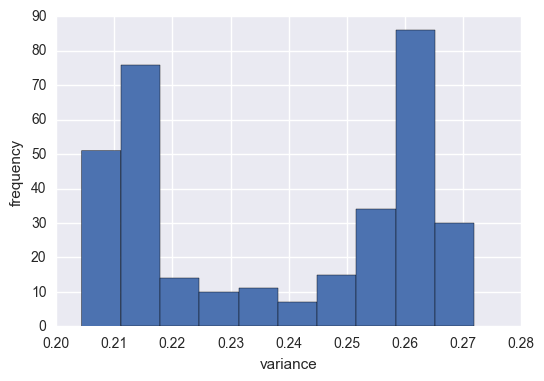

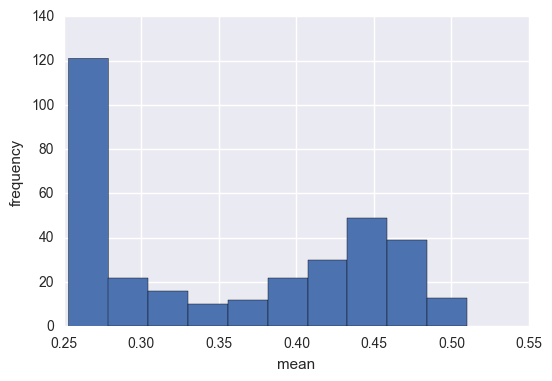

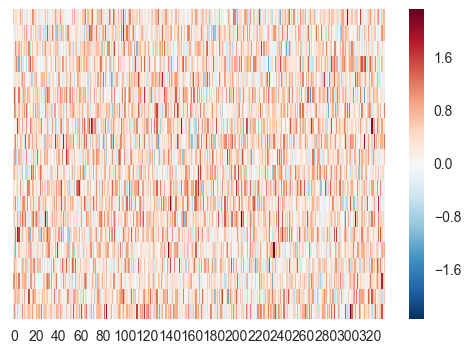

In [19]:
# generate a runid
initRunID()

# initialize logging
initLogging('HW3_run')

logger.info("Starting run ...")

# Reading files
read_start = time.time()

# Read in the data
X = pd.read_csv(TRAINING_DATA, sep='\t', header=None)
Y = pd.read_csv(TRAINING_TRUTH, sep='\t', header=None)
Xtest = pd.read_csv(TEST_DATA, sep="\t", header=None)

read_end = time.time()

# Print some timings
logger.info('Time to load data: %0.3fs' % (read_end - read_start))

# Log the size of data
logger.info('X.shape: %s, Y.shape: %s, Xtest.shape: %s' %
    (X.shape, Y.shape, Xtest.shape))

# Flatten output labels array
Y = np.array(Y).ravel()

# Do some data exploration
exploreData(X)

# Replace missing values
replaceMissingValues(X)

# Run randomforest classifier with gridsearch
#runRandomForestwithGridSearch(Y, X, Xtest)

# Run SVM classifier with gridsearch
# runSVMwithGridSearch(Y, X, Xtest)

# Run SVM classifier without gridsearch
runSVM(Y, X, Xtest)

# Run DecisionTree classifier with AdaBoost
runDecisionTreewithAdaboost(Y, X, Xtest)